In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

# Choices13k

The following notebook is intended to give a cursory overview of how to interpret and work with the data in choices13k. 

## Data Loading

Load the selection frequencies for the 13,006 problems in choices13k from the file `c13k_selections.csv`. The dataset contains the following columns:<br><br>


<center>

|   Column  |    Data Type    | Description                                                                                                                                                                                                                      |
|:---------:|:---------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  Problem  |     Integer     | A unique internal problem ID                                                                                                                                                                                                    |
|  Feedback |     Boolean     | Whether the participants were given feedback about the reward they received and missed out on after making their<br>selection.                                                                                                       |
|     n     |     Integer     | The number of subjects run on the current problem                                                                                                                                                                                |
|   Block   | {1, 2, 3, 4, 5} | The "block ID" for the current problem. For problems with no feedback, Block is always 1. Otherwise, Block ID was<br>sampled uniformly at random from {2, 3, 4, 5}.                                                                 |
|   bRate   |      Float      | The frequency with which subjects selected Gamble B on the current problem.                                       |
|     Ha    |     Integer     | The first outcome of gamble A
                              |
|    pHa    |      Float      | The probability of Ha in gamble A                                                                                   |
|     La    |     Integer     | The second outcome of gamble A (occurs with probability 1-pHa).                                                     |
|     Hb    |     Integer     | The expected value of the lottery in gamble B                                                                                                                                                                                         |
|    pHb    |      Float      | The probability of outcome Lb in gamble B                                                                                                                                                                                             |
|     Lb    |      Float      | The non-lottery outcome for gamble B (occurs with probability pHb)                                                                                                                                                                   |
| LotShapeB |   {0, 1, 2, 3}  | The shape of the lottery distribution for gamble B. A value of 1 indicates the distribution is symmetric around its mean,<br>2 indicates right-skewed, 3 indicates left-skewed, and 0 indicates undefined (i.e., if LotNumB = 1).    |
|  LotNumB  |     Integer     | The number of possible outcomes in the gamble B lottery                                                                                                                                                                               |
|    Amb    |     Boolean     | Whether the decision maker was able to see the probabilities of the outcomes in Gamble B. 1 indicates the participant<br>received no information concerning the probabilities, and 0 implies complete information and no ambiguity. |
|    Corr   |    {-1, 0, 1}   | Whether there is a correlation (negative, zero, or positive) between the payoffs of the two gambles.                                                                                                                            |
|   bRate   |    Float        | The ratio of gamble B selections to total selections for MTurk subjects.                                                                                                                             |
| bRate_std |    Float        | The standard deviation of the ratio of gamble B to total selections for MTurk subjects.                                                                                                                                    |
    
</center>

In [2]:
c13k_fp = "./c13k_selections.csv"
c13k = pd.read_csv(c13k_fp)

with pd.option_context('display.max_columns', None):
    display(c13k)

,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,LotShapeB,LotNumB,Amb,Corr,bRate,bRate_std
0,1,True,15,2,26,0.95,-1,23,0.05,21,0,1,False,0,0.626667,0.384460
1,2,True,15,4,14,0.60,-18,8,0.25,-5,0,1,True,-1,0.493333,0.413118
2,3,True,17,4,2,0.50,0,1,1.00,1,0,1,False,0,0.611765,0.432843
3,4,True,18,3,37,0.05,8,87,0.25,-31,1,2,False,0,0.222222,0.387383
4,5,False,15,1,26,1.00,26,45,0.75,-36,2,5,False,0,0.586667,0.450185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,13002,True,15,3,30,1.00,30,42,0.80,0,0,1,True,0,0.367619,0.302731
14564,13003,True,15,5,70,0.50,-42,18,0.80,7,0,1,False,0,0.760000,0.364104
14565,13004,True,15,5,8,0.40,-17,31,0.40,-34,1,6,False,0,0.666667,0.367747
14566,13005,True,15,2,89,0.50,-49,45,0.50,-12,0,1,False,0,0.386667,0.381476


Next, load outcomes and their associated probabilities for each problem in c13k from the file `c13k_problems.json`. This data can be joined straightforwardly against the c13k dataframe, as we demonstrate below. 

In `c13k_problems.json`, entries for each gamble are presented as a list of lists. Each sublist is of length 2, where the first entry is an outcome probability, and the second entry is the payout associated with that outcome. 

In [3]:
c13k_problems = pd.read_json("c13k_problems.json", orient='index')
c13k_problems

,B,A
0,"[[0.9500000000000001, 21.0], [0.05, 23.0]]","[[0.9500000000000001, 26.0], [0.05, -1.0]]"
1,"[[0.75, -5.0], [0.25, 8.0]]","[[0.6000000000000001, 14.0], [0.4, -18.0]]"
2,"[[1.0, 1.0]]","[[0.5, 2.0], [0.5, 0.0]]"
3,"[[0.75, -31.0], [0.125, 86.5], [0.125, 87.5]]","[[0.05, 37.0], [0.9500000000000001, 8.0]]"
4,"[[0.25, -36.0], [0.375, 41.0], [0.1875, 43.0],...","[[1.0, 26.0], [0.0, 26.0]]"
...,...,...
14563,"[[0.199999999999999, 0.0], [0.8, 42.0]]","[[1.0, 30.0], [0.0, 30.0]]"
14564,"[[0.199999999999999, 7.0], [0.8, 18.0]]","[[0.5, 70.0], [0.5, -42.0]]"
14565,"[[0.6000000000000001, -34.0], [0.0125, 28.5], ...","[[0.4, 8.0], [0.6000000000000001, -17.0]]"
14566,"[[0.5, -12.0], [0.5, 45.0]]","[[0.5, 89.0], [0.5, -49.0]]"


In [4]:
# join the gamble payout probability information against the entries in c13k 
c13k_w_gambles = c13k.join(c13k_problems, how="left")

with pd.option_context('display.max_columns', None):
    display(c13k_w_gambles)

,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,LotShapeB,LotNumB,Amb,Corr,bRate,bRate_std,B,A
0,1,True,15,2,26,0.95,-1,23,0.05,21,0,1,False,0,0.626667,0.384460,"[[0.9500000000000001, 21.0], [0.05, 23.0]]","[[0.9500000000000001, 26.0], [0.05, -1.0]]"
1,2,True,15,4,14,0.60,-18,8,0.25,-5,0,1,True,-1,0.493333,0.413118,"[[0.75, -5.0], [0.25, 8.0]]","[[0.6000000000000001, 14.0], [0.4, -18.0]]"
2,3,True,17,4,2,0.50,0,1,1.00,1,0,1,False,0,0.611765,0.432843,"[[1.0, 1.0]]","[[0.5, 2.0], [0.5, 0.0]]"
3,4,True,18,3,37,0.05,8,87,0.25,-31,1,2,False,0,0.222222,0.387383,"[[0.75, -31.0], [0.125, 86.5], [0.125, 87.5]]","[[0.05, 37.0], [0.9500000000000001, 8.0]]"
4,5,False,15,1,26,1.00,26,45,0.75,-36,2,5,False,0,0.586667,0.450185,"[[0.25, -36.0], [0.375, 41.0], [0.1875, 43.0],...","[[1.0, 26.0], [0.0, 26.0]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,13002,True,15,3,30,1.00,30,42,0.80,0,0,1,True,0,0.367619,0.302731,"[[0.199999999999999, 0.0], [0.8, 42.0]]","[[1.0, 30.0], [0.0, 30.0]]"
14564,13003,True,15,5,70,0.50,-42,18,0.80,7,0,1,False,0,0.760000,0.364104,"[[0.199999999999999, 7.0], [0.8, 18.0]]","[[0.5, 70.0], [0.5, -42.0]]"
14565,13004,True,15,5,8,0.40,-17,31,0.40,-34,1,6,False,0,0.666667,0.367747,"[[0.6000000000000001, -34.0], [0.0125, 28.5], ...","[[0.4, 8.0], [0.6000000000000001, -17.0]]"
14566,13005,True,15,2,89,0.50,-49,45,0.50,-12,0,1,False,0,0.386667,0.381476,"[[0.5, -12.0], [0.5, 45.0]]","[[0.5, 89.0], [0.5, -49.0]]"


With the combined gamble information and bRate data, we can write a function to provide a more human-readable version of the problem associated with a given c13k entry:

In [5]:
def print_problem(problem_df, problem_index):
    """
    Print a slightly more readable representation of the gamble information 
    for the gamble associated with index `problem_index` in `problem_df`.
    """
    entry = problem_df.loc[problem_index]
    gA, gB = entry.A, entry.B
    gambleA = pd.DataFrame(gA, columns=["Probability", "Payout"]).sort_values("Probability", ascending=False)
    gambleB = pd.DataFrame(gB, columns=["Probability", "Payout"]).sort_values("Probability", ascending=False)
    linesA = gambleA[["Payout", "Probability"]].to_string().split("\n")
    linesB = gambleB[["Payout", "Probability"]].to_string().split("\n")
    
    cols = ["Problem", "Feedback", "n", "Block", "bRate", "bRate_std"]
    print("{:^55}".format(f"Problem {entry.Problem}, Feedback = {entry.Feedback}"))
    print("{:^55}".format(f"n = {entry.n}, bRate = {entry.bRate:.4f}, std: {entry.bRate_std:.4f}"))
    print(f"\n{'Gamble A':^25} {'Gamble B':>20}")
    for i in range(max(len(linesA), len(linesB))):
        a_str = "" if i >= len(linesA) else linesA[i]
        b_str = "" if i >= len(linesB) else linesB[i]
        print(f"{a_str:<25} {b_str:>25}")

# print a human-readable version of the gamble information for index 0 in c13k_selections.csv.
# output suggests that human MTurk participants (n = 15) selected Gamble B approximately 63% 
# of the time on this problem. 
print_problem(c13k_w_gambles, 0)

              Problem 1, Feedback = True               
          n = 15, bRate = 0.6267, std: 0.3845          

        Gamble A                      Gamble B
   Payout  Probability          Payout  Probability
0    26.0         0.95       0    21.0         0.95
1    -1.0         0.05       1    23.0         0.05


## Descriptive Stats

### Feedback vs. no feedback problems

In [6]:
# inspect the ratio of feedback : no feedback problems in the dataset. as expected,
# no-feedback problems make up approximately 1/5 of the dataset, matching the base
# rates from CPC2015 and 2018.
all_problems = set(c13k.Problem.unique())
feedback_problems = set(c13k[c13k.Feedback == True].Problem.unique())
no_feedback_problems = set(c13k[c13k.Feedback == False].Problem.unique())

feedback_and_no_feedback_problems = feedback_problems.intersection(no_feedback_problems)
feedback_only_problems = (all_problems - feedback_and_no_feedback_problems).intersection(feedback_problems)
no_feedback_only_problems = (all_problems - feedback_and_no_feedback_problems).intersection(no_feedback_problems)

N = len(all_problems)
N_fbk = len(feedback_only_problems)
N_no_fbk = len(no_feedback_only_problems)
N_both = len(feedback_and_no_feedback_problems)

print(f"Total n. problems: {N}")
print(f"N. probs w. ONLY feedback condition: {N_fbk} ({(N_fbk / N) * 100:.2f}%)")
print(f"N. probs w. ONLY no feedback condition: {N_no_fbk} ({(N_no_fbk / N) * 100:.2f}%)")
print(f"N. probs w. BOTH feedback & no feedback conditions: {N_both} ({(N_both / N) * 100:.2f}%)")

Total n. problems: 13006
N. probs w. ONLY feedback condition: 10626 (81.70%)
N. probs w. ONLY no feedback condition: 818 (6.29%)
N. probs w. BOTH feedback & no feedback conditions: 1562 (12.01%)


### Participants per problem

In [7]:
# count the number of participants per problem. problems have on average 16 participants, 
# but there is a small subset with almost double this number due to Mechanical Turk errors.
N_ps = c13k.n.mean()
N_ps_feedback = c13k[c13k.Feedback == True].n.mean()
N_ps_no_feedback = c13k[c13k.Feedback == False].n.mean()

N_ps_just_feedback = c13k[c13k.Problem.isin(feedback_only_problems)].n.mean()
N_ps_just_no_feedback = c13k[c13k.Problem.isin(no_feedback_only_problems)].n.mean()
N_ps_just_both = c13k[c13k.Problem.isin(feedback_and_no_feedback_problems)].n.mean()

print(f"Avg. n. participants/problem: {N_ps:.2f}"),
print(f"Avg. n. participants/problem (all feedback problems): {N_ps_feedback:.2f}")
print(f"Avg. n. participants/problem (all no feedback problems): {N_ps_no_feedback:.2f}")
print(f"Avg. n. participants/problem (*only* feedback problems): {N_ps_just_feedback:.2f}")
print(f"Avg. n. participants/problem (*only* no feedback problems): {N_ps_just_no_feedback:.2f}")
print(f"Avg. n. participants/problem (*BOTH* feedback & no feedback problems): {N_ps_just_both:.2f}")
print("")
print(f"Fewest number of participants/problem: {c13k.n.min()}")
print(f"Largest number of participants/problem: {c13k.n.max()}")

Avg. n. participants/problem: 16.67
Avg. n. participants/problem (all feedback problems): 16.72
Avg. n. participants/problem (all no feedback problems): 16.40
Avg. n. participants/problem (*only* feedback problems): 16.80
Avg. n. participants/problem (*only* no feedback problems): 16.25
Avg. n. participants/problem (*BOTH* feedback & no feedback problems): 16.33

Fewest number of participants/problem: 15
Largest number of participants/problem: 33


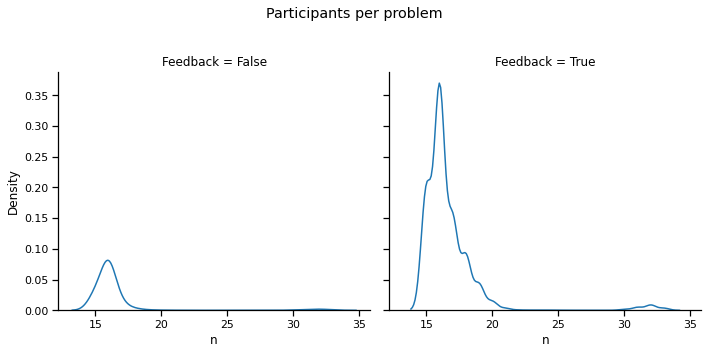

In [8]:
# plot the distribution of subjects per problem, organized by feedback 
# vs. no-feedback conditions. here it is easier to see the subset of 
# problems with a significantly higher participant count.
g = sns.displot(data=c13k, x="n", col="Feedback", kind="kde")
_ = g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle('Participants per problem')

### bRate distribution

In [9]:
# display entries with the largest variability in B-rates.
with pd.option_context('display.max_columns', None):
    print("Entries with largest bRate standard deviation:")
    display(c13k_w_gambles.sort_values("bRate_std", ascending=False).head(10))

Entries with largest bRate standard deviation:


,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,LotShapeB,LotNumB,Amb,Corr,bRate,bRate_std,B,A
1908,1560,True,16,2,30,1.00,30,30,1.00,30,2,2,True,0,0.487500,0.489728,"[[0.5, 29.0], [0.5, 31.0]]","[[1.0, 30.0], [0.0, 30.0]]"
48,39,True,18,2,-1,1.00,-1,23,0.20,-5,0,1,False,0,0.544444,0.488963,"[[0.8, -5.0], [0.2, 23.0]]","[[1.0, -1.0], [0.0, -1.0]]"
210,168,True,17,4,-1,0.20,-2,-2,1.00,-2,1,8,False,0,0.541176,0.488696,"[[0.0078125, -5.5], [0.0546875, -4.5], [0.1640...","[[0.2, -1.0], [0.8, -2.0]]"
9505,7944,True,17,5,-1,1.00,-1,104,0.10,-8,0,1,False,0,0.364706,0.485980,"[[0.9, -8.0], [0.1, 104.0]]","[[1.0, -1.0], [0.0, -1.0]]"
13676,12115,True,18,2,63,0.05,-12,-8,1.00,-8,0,1,False,0,0.455556,0.484127,"[[1.0, -8.0]]","[[0.05, 63.0], [0.9500000000000001, -12.0]]"
40,34,True,15,2,18,1.00,18,29,0.75,-16,3,2,True,0,0.480000,0.482849,"[[0.25, -16.0], [0.375, 30.0], [0.375, 28.0]]","[[1.0, 18.0], [0.0, 18.0]]"
7506,6067,False,16,1,28,1.00,28,31,0.60,30,2,5,False,0,0.575000,0.478191,"[[0.4, 30.0], [0.30000000000000004, 27.0], [0....","[[1.0, 28.0], [0.0, 28.0]]"
11797,10236,True,16,3,29,1.00,29,30,0.80,24,0,1,False,0,0.537500,0.477319,"[[0.199999999999999, 24.0], [0.8, 30.0]]","[[1.0, 29.0], [0.0, 29.0]]"
12928,11367,True,15,5,25,1.00,25,76,0.40,-11,0,1,False,0,0.493333,0.477294,"[[0.6000000000000001, -11.0], [0.4, 76.0]]","[[1.0, 25.0], [0.0, 25.0]]"
4919,4005,True,15,5,30,1.00,30,84,0.20,28,0,1,False,0,0.506667,0.477294,"[[0.8, 28.0], [0.2, 84.0]]","[[1.0, 30.0], [0.0, 30.0]]"


In [10]:
# also inspect problems that had the smallest amount of B-rate variability.
with pd.option_context('display.max_columns', None):
    print("Entries with smallest bRate standard deviation:")
    display(c13k_w_gambles.sort_values("bRate_std", ascending=True).head(10))

# you can use `print_problem` function defined above to inspect the specific gambles 
# print_problem(c13k_w_gambles, index=13814)

Entries with smallest bRate standard deviation:


,Problem,Feedback,n,Block,Ha,pHa,La,Hb,pHb,Lb,LotShapeB,LotNumB,Amb,Corr,bRate,bRate_std,B,A
13814,12253,True,15,5,3,1.0,3,-2,0.80,-4,1,8,False,0,0.0,0.0,"[[0.199999999999999, -4.0], [0.00625, -5.5], [...","[[1.0, 3.0], [0.0, 3.0]]"
706,568,True,17,3,6,1.0,6,17,0.10,13,3,2,False,0,1.0,0.0,"[[0.9, 13.0], [0.05, 18.0], [0.049999999999999...","[[1.0, 6.0], [0.0, 6.0]]"
9297,7736,True,15,4,-3,0.8,-22,54,0.01,2,0,1,True,-1,1.0,0.0,"[[0.99, 2.0], [0.01, 54.0]]","[[0.8, -3.0], [0.199999999999999, -22.0]]"
6263,5045,True,16,2,-10,1.0,-10,-11,0.95,-29,0,1,False,0,0.0,0.0,"[[0.05, -29.0], [0.9500000000000001, -11.0]]","[[1.0, -10.0], [0.0, -10.0]]"
1148,940,True,17,4,7,1.0,7,-2,0.01,-3,0,1,False,0,0.0,0.0,"[[0.99, -3.0], [0.01, -2.0]]","[[1.0, 7.0], [0.0, 7.0]]"
2564,2065,True,17,2,11,1.0,11,79,0.01,21,1,2,False,0,1.0,0.0,"[[0.99, 21.0], [0.005, 78.5], [0.005, 79.5]]","[[1.0, 11.0], [0.0, 11.0]]"
2572,2073,True,18,4,-4,1.0,-4,40,0.20,0,3,4,False,0,1.0,0.0,"[[0.8, 0.0], [0.1, 43.0], [0.05, 41.0], [0.025...","[[1.0, -4.0], [0.0, -4.0]]"
13331,11770,True,16,4,3,1.0,3,-1,0.80,-2,0,1,True,0,0.0,0.0,"[[0.199999999999999, -2.0], [0.8, -1.0]]","[[1.0, 3.0], [0.0, 3.0]]"
9893,8332,True,17,4,-3,1.0,-3,15,0.05,7,0,1,False,0,1.0,0.0,"[[0.9500000000000001, 7.0], [0.05, 15.0]]","[[1.0, -3.0], [0.0, -3.0]]"
1276,1050,False,16,1,2,1.0,2,-1,0.40,-6,0,1,False,0,0.0,0.0,"[[0.6000000000000001, -6.0], [0.4, -1.0]]","[[1.0, 2.0], [0.0, 2.0]]"


In [11]:
# count the number of problems that all participants agreed on
zero_brate_std = c13k[c13k.bRate_std == 0].shape[0]
zero_brate_std_fb = c13k[(c13k.bRate_std == 0) & (c13k.Feedback == True)].shape[0]
zero_brate_std_no_fb = c13k[(c13k.bRate_std == 0) & (c13k.Feedback == False)].shape[0]
    
print(f"Number of entries w. bRate standard deviation of 0: {zero_brate_std}")
print(f"Number of entries w. bRate standard deviation of 0(feedback): {zero_brate_std_fb}")
print(f"Number of entries w. bRate standard deviation of 0 (no feedback): {zero_brate_std_no_fb}")

Number of entries w. bRate standard deviation of 0: 26
Number of entries w. bRate standard deviation of 0(feedback): 24
Number of entries w. bRate standard deviation of 0 (no feedback): 2


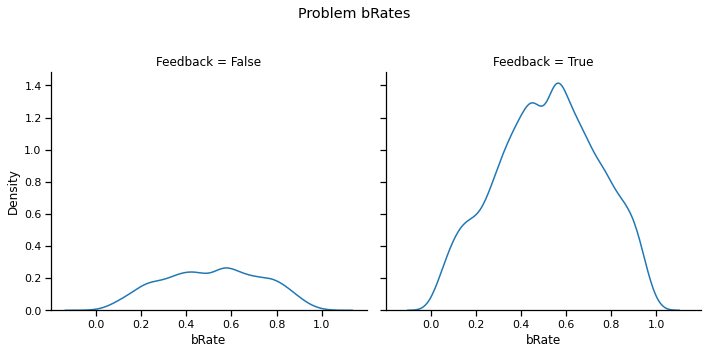

In [12]:
# look at the overall distribution of B-rates, stratified by Feedback
g = sns.displot(data=c13k, x="bRate", col="Feedback", kind="kde")
_ = g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle('Problem bRates')